In [1]:
import torch

# Loading CHEMBL dataset

In [ ]:
import os
import logging
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import SDWriter
from concurrent.futures import ThreadPoolExecutor, as_completed

# Set up logging to a file
log_file_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/logs'
os.makedirs(os.path.dirname(log_file_path), exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_file_path),
        logging.StreamHandler()  # To keep logging to console as well
    ]
)

logger = logging.getLogger(__name__)

# Initialize ChEMBL molecule client
molecule = new_client.molecule

# Define the query to fetch molecules with relevant properties
molecules = molecule.filter(molecule_properties__isnull=False, molecule_type='Small molecule').only(['molecule_chembl_id', 'molecule_structures', 'molecule_properties'])

# Function to process each molecule
def process_molecule(mol):
    try:
        chembl_id = mol['molecule_chembl_id']
        smiles = mol['molecule_structures'].get('canonical_smiles', "")
        molfile = mol['molecule_structures'].get('molfile', "")
        properties = mol['molecule_properties'] if mol['molecule_properties'] else {}
        mol_wt = properties.get('full_mwt')
        logp = properties.get('alogp')
        qed = properties.get('qed_weighted')
        
        # Create RDKit molecule object
        rdkit_mol = Chem.MolFromMolBlock(molfile)
        if rdkit_mol:
            rdkit_mol.SetProp('ChEMBL_ID', chembl_id)
            rdkit_mol.SetProp('SMILES', smiles)
            if mol_wt is not None:
                rdkit_mol.SetProp('Molecular_Weight', str(mol_wt))
            if logp is not None:
                rdkit_mol.SetProp('LogP', str(logp))
            if qed is not None:
                rdkit_mol.SetProp('QED', str(qed))
        
        logger.info(f"Processed molecule {chembl_id}")
        return rdkit_mol
    except Exception as e:
        logger.error(f"Error processing molecule {mol['molecule_chembl_id']}: {e}")
        return None

# Parallel processing of molecules
def process_all_molecules(molecules):
    rdkit_molecules = []
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = [executor.submit(process_molecule, mol) for mol in molecules]
        for future in as_completed(futures):
            result = future.result()
            if result:
                rdkit_molecules.append(result)
    return rdkit_molecules

# Save to SDF
def save_to_sdf(molecules, output_sdf_path):
    os.makedirs(os.path.dirname(output_sdf_path), exist_ok=True)
    writer = SDWriter(output_sdf_path)
    for mol in molecules:
        writer.write(mol)
    writer.close()
    logger.info(f"Saved {len(molecules)} molecules to {output_sdf_path}")

# Main execution
if __name__ == "__main__":
    rdkit_molecules = process_all_molecules(molecules)
    output_sdf_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_molecule_data.sdf'
    save_to_sdf(rdkit_molecules, output_sdf_path)

In [53]:
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import SDWriter
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

# Initialize ChEMBL molecule client
molecule = new_client.molecule

# Define the query to fetch molecules with relevant properties
molecules = molecule.filter(molecule_properties__isnull=False, molecule_type='Small molecule').only(['molecule_chembl_id', 'molecule_structures', 'molecule_properties'])

# Function to process each molecule
def process_molecule(mol):
    chembl_id = mol['molecule_chembl_id']
    smiles = mol['molecule_structures'].get('canonical_smiles', " ")
    molfile = mol['molecule_structures'].get('molfile', " ")
    properties = mol['molecule_properties'] if mol['molecule_properties'] else {}
    mol_wt = properties.get('full_mwt')
    logp = properties.get('alogp')
    qed = properties.get('qed_weighted')
    
    mol_data = {
        'ChEMBL_ID': chembl_id,
        'SMILES': smiles,
        'Molfile': molfile,
        'Molecular_Weight': mol_wt,
        'LogP': logp,
        'QED': qed
    }
    
    # Create RDKit molecule object
    rdkit_mol = Chem.MolFromMolBlock(molfile)
    if rdkit_mol:
        rdkit_mol.SetProp('ChEMBL_ID', chembl_id)
        rdkit_mol.SetProp('SMILES', smiles)
        if mol_wt is not None:
            rdkit_mol.SetProp('Molecular_Weight', str(mol_wt))
        if logp is not None:
            rdkit_mol.SetProp('LogP', str(logp))
        if qed is not None:
            rdkit_mol.SetProp('QED', str(qed))
    
    return rdkit_mol

In [54]:
# Parallel processing of molecules
rdkit_molecules = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = [executor.submit(process_molecule, mol) for mol in molecules]
    for future in as_completed(futures):
        result = future.result()
        if result:
            rdkit_molecules.append(result)

[17:37:29] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 10 ignored.
[17:37:29] Warning: ambiguous stereochemistry - opposing bonds have opposite wedging - at atom 10 ignored.
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 65 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 14 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 77 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 97 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 81 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 82 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 85 ignored
[17:37:43] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 86 ignored
[17:37:43] Warning: ambiguous ster

In [ ]:
# Save to SDF
output_sdf_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_molecule_data.sdf'  # Update this path as needed
writer = SDWriter(output_sdf_path)
for mol in rdkit_molecules:
    writer.write(mol)
writer.close()

print(f"Saved {len(rdkit_molecules)} molecules to {output_sdf_path}")

# ChemBL dataset exploration

In [40]:
from rdkit import Chem
from rdkit.Chem import PandasTools
import pandas as pd

In [35]:
sdf_file_path = "/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_34.sdf"

# Open and read the SDF file
supplier = Chem.SDMolSupplier(sdf_file_path)

[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 14 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 27 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 40 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 44 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 20 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 17 ignored
[16:13:23] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 28 ignored
[16:13:25] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 65 ignored
[16:13:25] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 14 ignored
[16:13:25] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 77 ignored
[16:13:25] Warning: ambiguous stereochemistry - zero final c

,chembl_id,ID,ROMol
0,CHEMBL153534,CHEMBL153534,
1,CHEMBL440060,CHEMBL440060,
2,CHEMBL440245,CHEMBL440245,
3,CHEMBL440249,CHEMBL440249,
4,CHEMBL405398,CHEMBL405398,
...,...,...,...
2409265,CHEMBL4298696,CHEMBL4298696,
2409266,CHEMBL4298698,CHEMBL4298698,
2409267,CHEMBL4298702,CHEMBL4298702,
2409268,CHEMBL4298703,CHEMBL4298703,

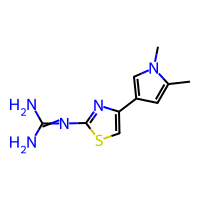
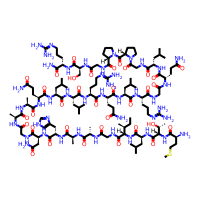
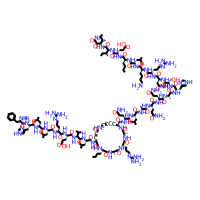
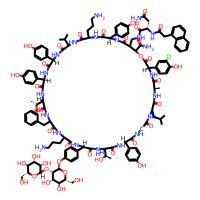
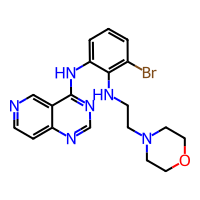
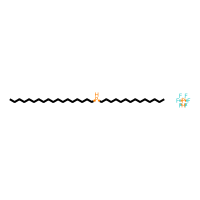
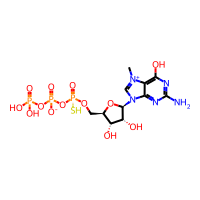
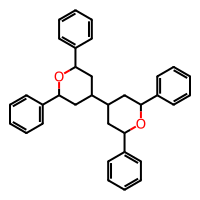
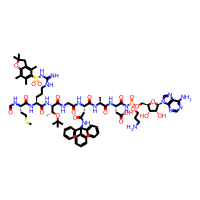
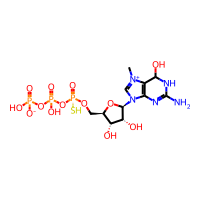

In [36]:
# Read the SDF file into a Pandas DataFrame
df = PandasTools.LoadSDF(sdf_file_path, molColName='ROMol', removeHs=False)
df

# Chembl_molecule_data

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

# Load the SDF file into a Pandas DataFrame
sdf_file = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_molecule_data.sdf'
suppl = Chem.SDMolSupplier(sdf_file)

# Create a Pandas DataFrame with molecules
molecules = [mol for mol in suppl if mol is not None]
df = PandasTools.LoadSDF(sdf_file)

[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 12 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 6 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 12 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 13 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 16 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 15 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 1 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 2 ignored
[09:37:47] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 2 ignored
[09:37:50] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 17 ignored
[09:37:50] Warning: ambiguous stereochemistry - linear bond arrangement - 

In [2]:
df.head()

,ChEMBL_ID,SMILES,Molecular_Weight,LogP,QED,ID,ROMol
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,341.75,2.11,0.74,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d54b0>
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,332.32,1.33,0.73,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d5570>
2,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,357.80,2.27,0.75,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d5630>
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,307.31,1.46,0.74,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d5690>
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,341.75,2.11,0.74,,<rdkit.Chem.rdchem.Mol object at 0x14ff909d5750>


In [3]:
df.shape

(1741263, 7)

# Exploartion of Exhaustive search on QED

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

#unimolecular reaction templates (SMARTS strings)
unimolecular_reactions = []

# bimolecular reaction templates (SMARTS strings)
bimolecular_reactions = []

# Create reaction objects from SMARTS strings
uni_reactions = [AllChem.ReactionFromSmarts(smart) for smart in unimolecular_reactions]
bi_reactions = [AllChem.ReactionFromSmarts(smart) for smart in bimolecular_reactions]

In [ ]:
import pandas as pd
from rdkit.Chem import QED

# Function to apply a unimolecular reaction template to a molecule and generate products
def apply_unimolecular_reaction(mol, reaction):
    products = reaction.RunReactants((mol,))
    return [Chem.MolToSmiles(prod[0]) for prod in products if prod]

# Function to apply a bimolecular reaction template to a pair of molecules and generate products
def apply_bimolecular_reaction(mol1, mol2, reaction):
    products = reaction.RunReactants((mol1, mol2))
    return [Chem.MolToSmiles(prod[0]) for prod in products if prod]

# Function to calculate QED score for a molecule
def calculate_qed(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return QED.qed(mol)

# Main function to perform exhaustive search for QED optimization
def optimize_qed_for_dataset(input_file, output_file):
    df = pd.read_csv(input_file)
    results = []

    molecules = [Chem.MolFromSmiles(smiles) for smiles in df['smiles']]

    for mol in molecules:
        if mol is None:
            continue

        best_smiles = Chem.MolToSmiles(mol)
        best_qed = calculate_qed(best_smiles)

        # Apply unimolecular reactions
        for reaction in uni_reactions:
            product_smiles_list = apply_unimolecular_reaction(mol, reaction)
            for product_smiles in product_smiles_list:
                qed_score = calculate_qed(product_smiles)
                if qed_score and qed_score > best_qed:
                    best_qed = qed_score
                    best_smiles = product_smiles

        # Apply bimolecular reactions
        for other_mol in molecules:
            if other_mol is mol:
                continue
            for reaction in bi_reactions:
                product_smiles_list = apply_bimolecular_reaction(mol, other_mol, reaction)
                for product_smiles in product_smiles_list:
                    qed_score = calculate_qed(product_smiles)
                    if qed_score and qed_score > best_qed:
                        best_qed = qed_score
                        best_smiles = product_smiles

        results.append({'original_smiles': Chem.MolToSmiles(mol), 'optimized_smiles': best_smiles, 'qed_score': best_qed})

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)

In [ ]:
# usage
input_file = 'molecules.csv'
output_file = 'optimized_molecules.csv'
optimize_qed_for_dataset(input_file, output_file)

# Random Search Baseline
1. Load data
2. Generate Molecules
3. Apply Random search algorithm

In [79]:
from rdkit import Chem
from rdkit.Chem import AllChem, QED
import random
import pandas as pd

In [13]:
def parse_template(smarts):
    try:
        if ">>" in smarts:
            reactant_smarts, _ = smarts.split(">>")
        elif ">" in smarts:
            parts = smarts.split('>')
            if len(parts) == 3:
                reactant_smarts, _, _ = parts
            else:
                raise ValueError(f"Invalid SMARTS format: {smarts}")
        else:
            raise ValueError(f"Invalid SMARTS format: {smarts}")
        return reactant_smarts
    except Exception as e:
        print(f"Error parsing SMARTS: {smarts}, {e}")
        return None

def substructure_match(reactant_smiles, template_smarts, use_chirality=False):
    try:
        reactant = Chem.MolFromSmiles(reactant_smiles)
        pattern = Chem.MolFromSmarts(template_smarts)
        if pattern is None:
            return False
        return reactant.HasSubstructMatch(pattern, use_chirality=use_chirality)
    except Exception as e:
        print(f"Error in substructure matching: {e}")
        return False

def apply_template(reactant1, smarts, reactant2=None, type="unimolecular"):
    reactant1_mol = Chem.MolFromSmiles(reactant1)
    if not reactant1_mol:
        return None
    if type == 'unimolecular':
        rxn = AllChem.ReactionFromSmarts(smarts)
        products = rxn.RunReactants(reactant1_mol)
    elif type == 'bimolecular' and reactant2:
        reactant2_mol = Chem.MolFromSmiles(reactant2)
        if not reactant2_mol:
            return None
        rxn = AllChem.ReactionFromSmarts(smarts)
        products = rxn.RunReactants((reactant1_mol, reactant2_mol))
    else:
        return None
    
    if products:
        return [Chem.MolToSmiles(product[0]) for product in products if product]
    return None

def compute_qed(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return QED.qed(mol)
        return None
    except Exception as e:
        print(f"Error computing QED: {e}")
        return None

In [14]:
def random_search(reactants, templates, max_steps=5, max_reactions=10):
    results = []
    total_reactions = 0

    while total_reactions < max_reactions:
        initial_reactant = random.choice(reactants)
        current_reactant = initial_reactant
        sequence = [{'step': 0, 'reactant': initial_reactant, 'template': None, 'product': initial_reactant, 'qed': compute_qed(initial_reactant)}]
        
        for step in range(1, max_steps + 1):
            if total_reactions >= max_reactions:
                break
            
            # Get compatible templates
            compatible_templates = []
            for _, template in templates.iterrows():
                template_smarts = parse_template(template.Smarts)
                if template.Type == 'unimolecular':
                    if substructure_match(current_reactant, template_smarts):
                        compatible_templates.append(template)
                    else:
                        continue
                elif template.Type == 'bimolecular':
                    r1_smarts = template_smarts.split('.')[0]
                    r2_smarts = template_smarts.split('.')[-1]
                    if substructure_match(current_reactant, r1_smarts):
                        compatible_templates.append(template)
                    else:
                        continue

            if not compatible_templates:
                break  # No compatible templates found for the current reactant
            
            template = random.choice(compatible_templates)
            template_smarts = parse_template(template.Smarts)

            if template.Type == 'unimolecular':
                products = apply_template(current_reactant, template.Smarts, type='unimolecular')
                if products:
                    best_product = max(products, key=compute_qed)
                    qed_score = compute_qed(best_product)
                    sequence.append({'step': step, 'reactant': current_reactant, 'template': template.Reaction, 'product': best_product, 'qed': qed_score})
                    current_reactant = best_product
                    total_reactions += 1
                else:
                    continue

            elif template.Type == 'bimolecular':
                r1_smarts, r2_smarts = template_smarts.split('.')
                compatible_reactants = [r for r in reactants if substructure_match(r, r2_smarts)]
                
                if not compatible_reactants:
                    continue
                
                second_reactant = random.choice(compatible_reactants)
                products = apply_template(current_reactant, template.Smarts, reactant2=second_reactant, type='bimolecular')
                if products:
                    best_product = max(products, key=compute_qed)
                    qed_score = compute_qed(best_product)
                    sequence.append({'step': step, 'reactant': current_reactant, 'second_reactant': second_reactant, 'template': template.Reaction, 'product': best_product, 'qed': qed_score})
                    current_reactant = best_product
                    total_reactions += 1
        
        results.append(sequence)
    
    return results

In [15]:
r_enamine = random.sample(enamine_df.SMILES.to_list(), 2)

In [16]:
r_enamine

['CC(C)(C)OC(=O)N1CCN(C2(C(=O)O)CCOC2)CC1', 'CCCn1cc(Cl)cn1']

In [ ]:
# Perform Random Search
random_search_results = random_search(r_enamine, rxn_df_copy)

# Exploring reaction templates

In [1]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [13]:
rxn_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/rxn_set.txt", delimiter="|", names=["Reaction", "Smarts", "Label"])

In [14]:
rxn_df.head()

,Reaction,Smarts,Label
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",DINGOS Reaction
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",DINGOS Reaction
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",DINGOS Reaction
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",DINGOS Reaction
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",DINGOS Reaction


In [15]:
def rxn_type(reaction_template):
    rxn = AllChem.ReactionFromSmarts(reaction_template)
    if rxn.GetNumReactantTemplates() > 1:
        type = "bimolecular"
    else:
        type = "unimolecular"
    return type

In [16]:
rxn_df["Type"] = rxn_df["Smarts"].apply(rxn_type)

In [17]:
rxn_df.drop(columns='Label', inplace=True)

In [18]:
rxn_df["Type"].value_counts()

Type
bimolecular     49
unimolecular    15
Name: count, dtype: int64

In [19]:
rxn_df.head()

,Reaction,Smarts,Type
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",bimolecular


In [21]:
rxn_df.to_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_set_processed.txt",
              sep="|",
              columns=["Reaction", "Smarts", "Type"],
              index=False)

In [22]:
reactants_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/enamine_building_blocks.csv")

In [23]:
reactants_df.shape

(150560, 1)

In [24]:
reactants_df.head()

,SMILES
0,CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...
1,CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c...
2,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...
3,CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...
4,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...


In [25]:
import random
random_val_set= random.sample(list(reactants_df["SMILES"]), 2000)

In [26]:
len(random_val_set)

2000

In [41]:
# Read the SDF file into a Pandas DataFrame
df = PandasTools.LoadSDF('/rds/user/gtj21/hpc-work/designing-new-molecules/data/chembl_molecule_data.sdf')

[21:39:10] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 12 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 6 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 12 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 13 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 16 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 15 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 1 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 2 ignored
[21:39:11] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 2 ignored
[21:39:17] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 17 ignored
[21:39:17] Warning: ambiguous stereochemistry - linear bond arrangement - 

In [47]:
df.head()

,ChEMBL_ID,SMILES,Molecular_Weight,LogP,QED,ID,ROMol
0,CHEMBL6329,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccccc1Cl,341.75,2.11,0.74,,<rdkit.Chem.rdchem.Mol object at 0x149cf84a53f0>
1,CHEMBL6328,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(C#N)cc1,332.32,1.33,0.73,,<rdkit.Chem.rdchem.Mol object at 0x149cf8369150>
2,CHEMBL265667,Cc1cc(-n2ncc(=O)[nH]c2=O)cc(C)c1C(O)c1ccc(Cl)cc1,357.80,2.27,0.75,,<rdkit.Chem.rdchem.Mol object at 0x149cf8369270>
3,CHEMBL6362,Cc1ccc(C(=O)c2ccc(-n3ncc(=O)[nH]c3=O)cc2)cc1,307.31,1.46,0.74,,<rdkit.Chem.rdchem.Mol object at 0x149cf83692d0>
4,CHEMBL267864,Cc1cc(-n2ncc(=O)[nH]c2=O)ccc1C(=O)c1ccc(Cl)cc1,341.75,2.11,0.74,,<rdkit.Chem.rdchem.Mol object at 0x149cf8369390>


# Data exploration of Enamine building blocks and Reaction Template

In [3]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

In [4]:
enamine_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/enamine_building_blocks.csv")
rxn_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_set_processed.txt", delimiter="|")

In [5]:
enamine_df.head()

,SMILES
0,CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...
1,CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c...
2,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...
3,CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...
4,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...


In [6]:
enamine_df.describe()

,SMILES
count,150560
unique,150560
top,CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...
freq,1


In [7]:
rxn_df.head()

,Reaction,Smarts,Type
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",bimolecular


In [8]:
rxn_df.describe()

,Reaction,Smarts,Type
count,64,64,64
unique,64,64,2
top,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",bimolecular
freq,1,1,49


In [9]:
count = 0
index = []
temp =[]
for i, template in rxn_df.iterrows():
    if ">>" in template.Smarts:
        continue
    elif ">" in template.Smarts:
        count += 1
        index.append(i)
        temp.append(template)
    else:
        pass

In [10]:
rxn_df_copy = rxn_df.drop(index = index)

In [11]:
rxn_df_copy.describe()

,Reaction,Smarts,Type
count,60,60,60
unique,60,60,2
top,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",bimolecular
freq,1,1,46


## Reactants and Tempalte Matching: Pref-filtering

In [10]:
def parse_template(smarts):
    try:
        if ">>" in smarts:
            reactant_smarts, _= smarts.split(">>")
        elif ">" in smarts:
            parts = smarts.split('>')
            if len(parts) == 3:
                reactant_smarts, _, _ = parts
            else:
                raise ValueError(f"Invalid SMARTS format: {smarts}")
        else:
            raise ValueError(f"Invalid SMARTS format: {smarts}")
        return reactant_smarts
    except Exception as e:
            print(f"Error parsing SMARTS: {smarts}, {e}")
            return None, None

def substructure_match(reactant, smarts, use_chirality=False):
    try:
        reactant = Chem.MolFromSmiles(reactant)
        pattern = Chem.MolFromSmarts(smarts)
        if pattern is None:
            return False
        return reactant.HasSubstructMatch(pattern, useChirality=use_chirality)
    except Exception as e:
        print(f"Error in substructure matching: {e}")
        return False   

In [8]:
parse_template(rxn_df["Smarts"][2])

'[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)),C$([CH2](N)(C)):8]-[C$(C(c)(C)(C)(C)),C$([CH](c)(C)(C)),C$([CH2](c)(C)):7]-[c:6]1[c:1][c:2][c:3][c:4][cH:5]1.[CH:10](-[CX4:12])=[O:11]'

In [46]:
substructure_match(enamine_df.SMILES[9], '[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)),C$([CH2](N)(C)):8]-[C$(C(c)(C)(C)(C)),C$([CH](c)(C)(C)),C$([CH2](c)(C)):7]-[c:6]1[c:1][c:2][c:3][c:4][cH:5]1')

False

In [30]:
def pre_filter_unimolecular(reactants, template):
    return [r for r in reactants if substructure_match(r, template)]

def pre_filter_bimolecular_first(reactants, template):
    # Assumes the first reactant in the SMARTS pattern is denoted by [R1]
    first_reactant_smarts = template.split('.')[0]
    return [r for r in reactants if substructure_match(r, first_reactant_smarts)]

def pre_filter_bimolecular_second(reactants, template):
    # Assumes the second reactant in the SMARTS pattern is denoted by [R2]
    second_reactant_smarts = template.split('.')[-1]
    return [r for r in reactants if substructure_match(r, second_reactant_smarts)]

In [ ]:
def analyse_compatibility(reactants, templates, use_chirality=False):
    reactants = reactants.SMILES
    compatibility_results = []
    
    for _, template in templates.iterrows():
        if template.Type == "unimolecular":
            smarts = parse_template(template.Smarts)
            filtered_reactants = pre_filter_unimolecular(reactants, smarts)
            for reactant in filtered_reactants:
                compatibility_results.append((smarts, reactant))
        elif template.Type == "bimolecular":
            smarts = parse_template(template.Smarts)
            first_reactants = pre_filter_bimolecular_first(reactants, smarts)
            second_reactants = pre_filter_bimolecular_second(reactants, smarts)
            for reactant1 in first_reactants:
                for reactant2 in second_reactants:
                    compatibility_results.append((smarts, reactant1, reactant2))
    return compatibility_results

In [58]:
def analyse_compatibility(reactants, templates, use_chirality=False):
    reactants = reactants.SMILES
    unimolecular_counts = []
    bimolecular_counts = []
    
    for _, template in templates.iterrows():
        if template.Type == "unimolecular":
            smarts = parse_template(template.Smarts)
            count = 0
            for r in reactants:
                if substructure_match(r, smarts):
                    count += 1
            unimolecular_counts.append((template.Reaction, count))
            pass
        elif template.Type == "bimolecular":
            smarts = parse_template(template.Smarts)
            # Assumes the first and second reactant in the SMARTS pattern are denoted by [r_1] and [r_2] respectively
            r_1_smarts = smarts.split(".")[0]
            r_2_smarts = smarts.split(".")[-1]
            count_1 = 0
            count_2 = 0
            for r in reactants:
                if substructure_match(r, r_1_smarts):
                    count_1 += 1
                if substructure_match(r, r_2_smarts):
                    count_2 += 1

            bimolecular_counts.append((template.Reaction, count_1, count_2))

    return unimolecular_counts, bimolecular_counts

In [60]:
unimolecular_counts, bimolecular_counts = analyse_compatibility(enamine_df, rxn_df)

In [61]:
unimolecular_counts

[('Bischler-Napieralski', 159),
 ('Pictet-Gams', 9),
 ('Aminothiazol_formation', 925),
 ('Chinonlin-2-one_Intramol', 43),
 ('Tetrazol_formation', 3732),
 ('Dieckmann_5-ring', 18),
 ('Dieckmann_6-ring', 13),
 ('FGI_Acyl_chloride', 19838),
 ('FGI_bromination', 20484),
 ('FGI_chlorination', 20484),
 ('FGI_sulfonyl_chloride', 78),
 ('FGA_alpha_bromination', 16329),
 ('FGA_alpha_chlorination', 16329),
 ('FGI_Rosenmund-von_Braun', 20834),
 ('FGI_nitrilation', 16347)]

In [62]:
bimolecular_counts

[('Pictet-Spengler-6-membered-ring', 1254, 976),
 ('Pictet-Spengler-5-membered-ring', 129, 976),
 ('Bischler-Indole', 7409, 150),
 ('Benzimidazol_formation', 19838, 297),
 ('Benzoxazol_formation', 19838, 162),
 ('Benzothiazol_formation', 19838, 41),
 ('Rap-Stoermer', 115, 168),
 ('Niementowski', 5608, 209),
 ('Quinazolinone_formation', 21035, 209),
 ('Tetrahydro-Indole_formation', 21063, 128),
 ('3-nitrile_pyridine', 97, 1),
 ('Triazole_formation', 3732, 586),
 ('Huisgen_1-3_Dipolar_Cycloaddition', 96, 749),
 ('Huisgen_1_3_Dipolar_Cycloaddition_double_bond', 1414, 749),
 ('Diels-Alder', 2576, 30),
 ('Diels-Alder-Alkyne', 1190, 30),
 ('Spiro-piperidine_formation', 272, 114),
 ('Pyrazol_formation', 250, 127),
 ('Phthalazinone', 250, 38),
 ('Paal-Knorr-pyrole_formation', 27, 21063),
 ('Triaryl-imidazol-1_2-diketone', 2388, 10),
 ('Triaryl-imidazol-alpha_hydroxy_ketone', 2388, 4),
 ('Fischer_indole', 3195, 265),
 ('Friedlaender_chinoline_formation', 3195, 49),
 ('Peachmann_coumarine', 4040

In [80]:
unim = pd.DataFrame(unimolecular_counts, columns=['Reaction', 'First Reactants'])

In [81]:
bim = pd.DataFrame(bimolecular_counts, columns=['Reaction', 'First Reactants', 'Second Reactants'])

In [83]:
unim_bim = pd.concat([unim, bim], axis=0).reset_index(drop=True)

In [88]:
pd.merge(rxn_df, unim_bim, on="Reaction").to_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_count.txt",
                                                 sep="|",
                                                 index=False)

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
rxn_count = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_count.txt", delimiter="|")

In [108]:
rxn_count.head()

,Reaction,Smarts,Type,First Reactants,Second Reactants
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular,159,NaN
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular,9,NaN
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular,1254,976.0
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular,129,976.0
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]...",bimolecular,7409,150.0


In [99]:
a = rxn_count[rxn_df["Type"] == "unimolecular"]

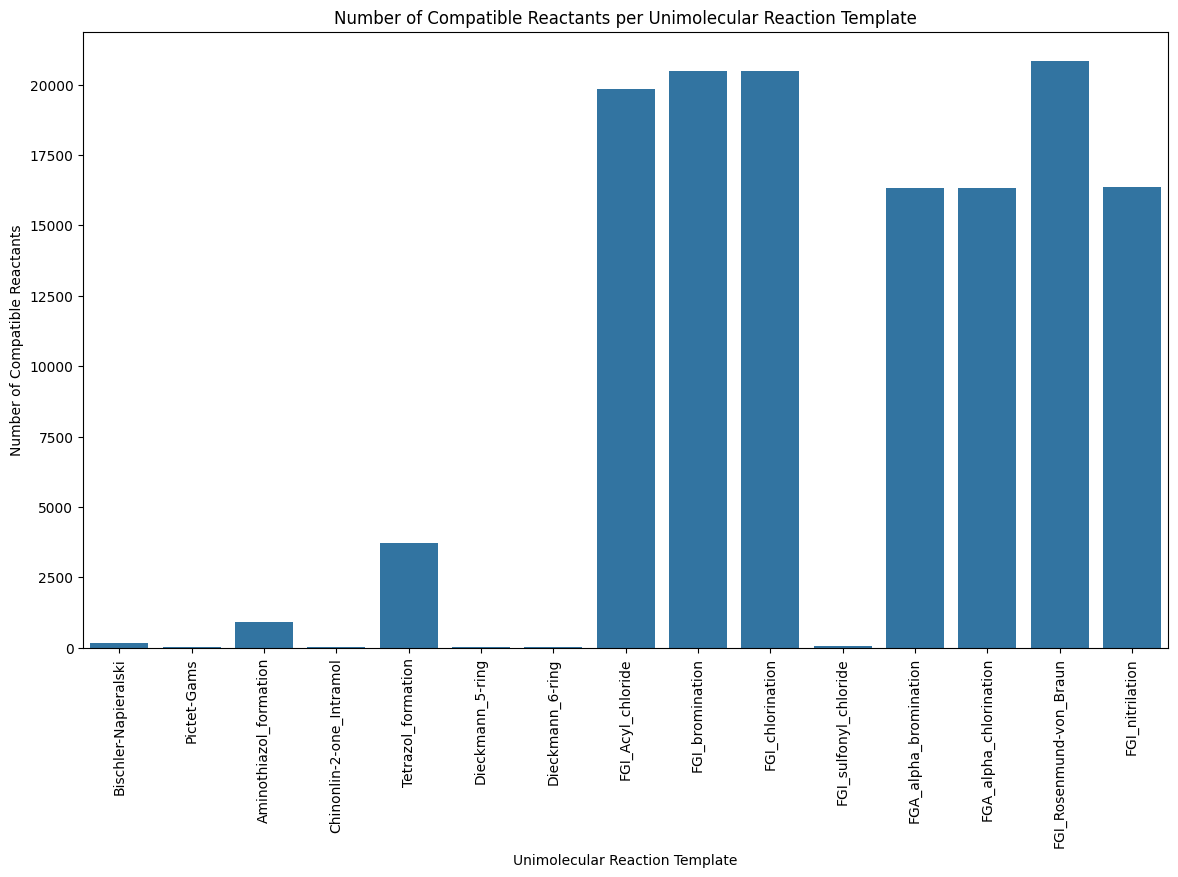

In [101]:
# Plot the results for unimolecular templates
plt.figure(figsize=(14, 8))
sns.barplot(x='Reaction', y='First Reactants', data=a)
plt.title('Number of Compatible Reactants per Unimolecular Reaction Template')
plt.xlabel('Unimolecular Reaction Template')
plt.ylabel('Number of Compatible Reactants')
plt.xticks(rotation=90)
plt.show()

In [104]:
b = rxn_count[rxn_df["Type"] == "bimolecular"]

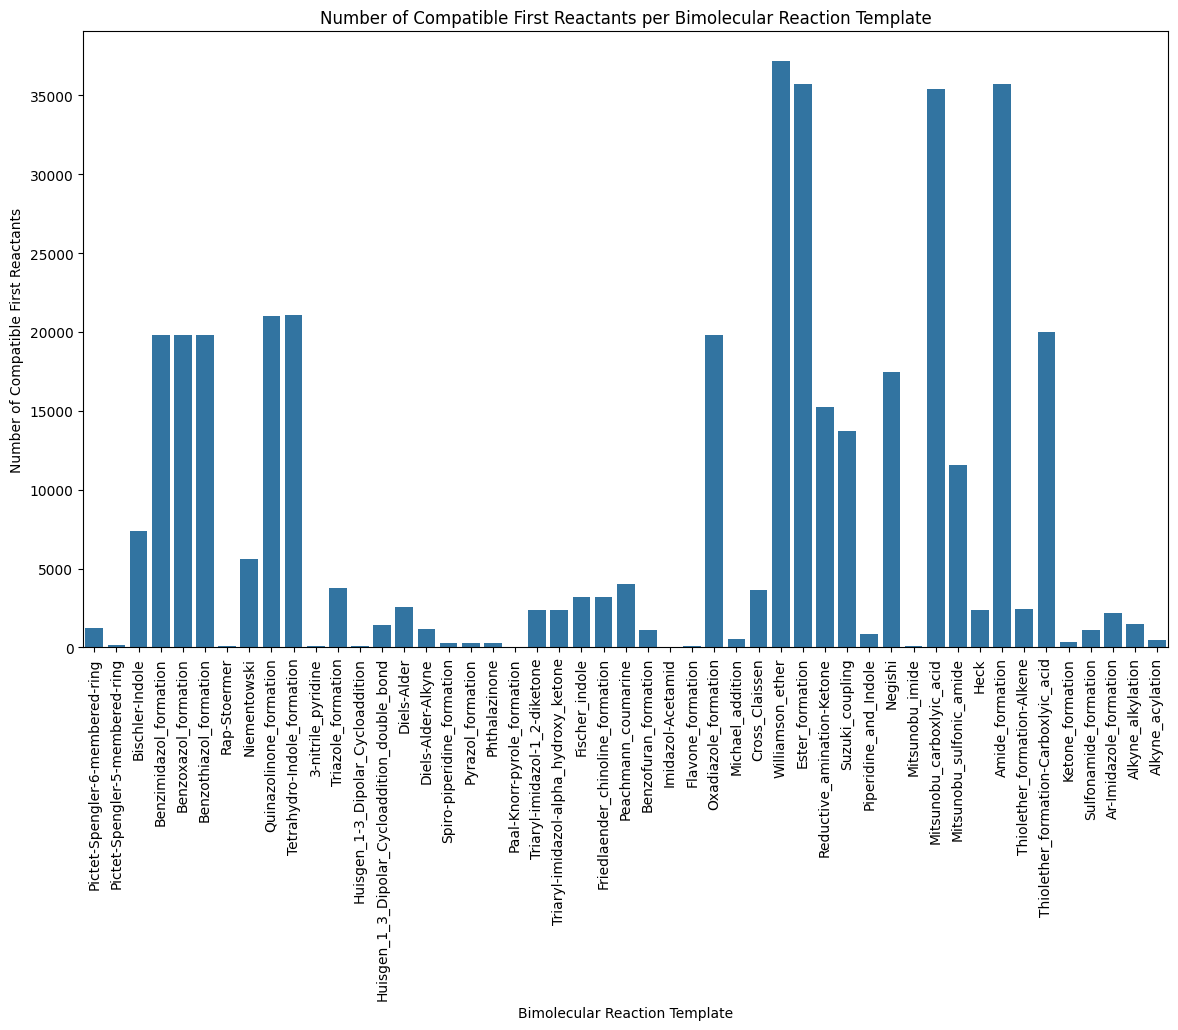

In [106]:
# Plot the results for bimolecular templates (first reactants)
plt.figure(figsize=(14, 8))
sns.barplot(x='Reaction', y='First Reactants', data=b)
plt.title('Number of Compatible First Reactants per Bimolecular Reaction Template')
plt.xlabel('Bimolecular Reaction Template')
plt.ylabel('Number of Compatible First Reactants')
plt.xticks(rotation=90)
plt.show()

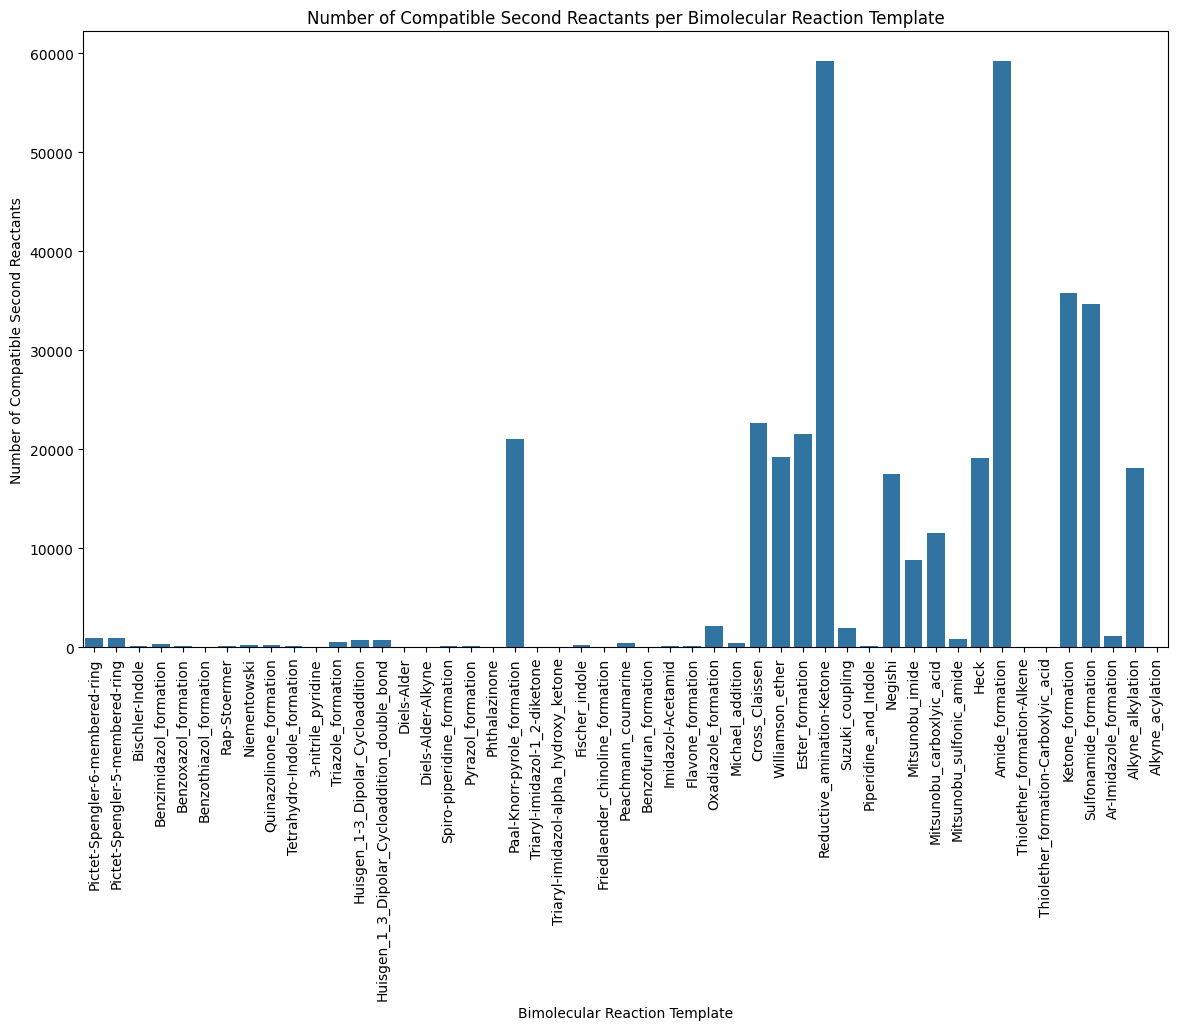

In [107]:
# Plot the results for bimolecular templates (second reactants)
plt.figure(figsize=(14, 8))
sns.barplot(x='Reaction', y='Second Reactants', data=b)
plt.title('Number of Compatible Second Reactants per Bimolecular Reaction Template')
plt.xlabel('Bimolecular Reaction Template')
plt.ylabel('Number of Compatible Second Reactants')
plt.xticks(rotation=90)
plt.show()

In [125]:
def count_matching_templates(reactants, templates):
    reactants = reactants.SMILES
    counts = []
    for reactant in reactants:
        count = 0
        for _, template in templates.iterrows():
            if template.Type == "unimolecular":
                smarts = parse_template(template.Smarts)
                if substructure_match(reactant, smarts):
                    count += 1
                else:
                    continue
            elif template.Type == "bimolecular":
                smarts = parse_template(template.Smarts)
            # Assumes the first and second reactant in the SMARTS pattern are denoted by [r_1] and [r_2] respectively
                r_1_smarts = smarts.split(".")[0]
                r_2_smarts = smarts.split(".")[-1]
                if substructure_match(reactant, r_1_smarts):
                    count += 1
                else:
                    continue
        counts.append((reactant, count))
    return counts

In [128]:
# Count the number of matching templates for each reactant
matching_counts = count_matching_templates(enamine_df, rxn_df)

In [ ]:
matching_counts

# PGFS Implementation playground

In [39]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

# Define a reaction in SMARTS format
reaction_smarts = '[C$([CH](=C)([CX4])),C$([CH2](=C)):2]=[C$(C(=C)([CX4])([CX4])),C$([CH](=C)([CX4])),C$([CH2](=C)):3].[Br,I:7][C$([CX4]([Br,I])),c$([c]([Br,I])):4]>>[C,c:4][C:2]=[C:3]'
reaction = AllChem.ReactionFromSmarts(reaction_smarts)

In [46]:
r1 =Chem.MolFromSmiles("NCCCCc1ccncc1") #no valid template: CCC(NCC(C)C)c1ccccc1
r2=Chem.MolFromSmiles("ClCI")

In [41]:
# Get the number of reactant templates
num_reactants = reaction.GetNumReactantTemplates()
print(f'Number of reactant templates: {num_reactants}')

Number of reactant templates: 2


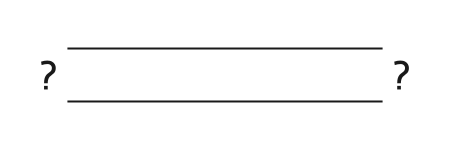

In [43]:
reaction.GetReactantTemplate(0)

In [45]:
r2.HasSubstructMatch(reaction.GetReactantTemplate(1))

True

In [5]:
t = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_set_processed.txt", delimiter="|")

In [6]:
t = t.Smarts.tolist()

In [47]:
mask = []
for i in t:
    rxn = AllChem.ReactionFromSmarts(i)
    mask.append(r1.HasSubstructMatch(rxn.GetReactantTemplate(0)))

In [48]:
mask

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [49]:
i_mask = []
for i,v in enumerate(mask):
    if v == True:
        i_mask.append(i)
i_mask

[]

In [37]:
reaction_smarts = t[46]
reaction = AllChem.ReactionFromSmarts(reaction_smarts)
r1.HasSubstructMatch(reaction.GetReactantTemplate(0))

True

In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# Define a list of molecular descriptors
descriptor_names = [
    'MaxEStateIndex', 'MinEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'FpDensityMorgan1', 'BalabanJ',
    'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA7', 'SlogP_VSA3',
    'SlogP_VSA4', 'SlogP_VSA5', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6',
    'FractionCSP3', 'MolLogP', 'Kappa2', 'PEOE_VSA2', 'SMR_VSA5', 'SMR_VSA6', 'EState_VSA7', 'Chi4v', 'SMR_VSA10',
    'SlogP_VSA6', 'EState_VSA8', 'EState_VSA9', 'VSA_EState9'
]

# Initialize the MolecularDescriptorCalculator with the list of descriptors
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

# Example molecule in SMILES format
smiles = "CCO"
mol = Chem.MolFromSmiles(smiles)

# Calculate the descriptors
descriptors = calculator.CalcDescriptors(mol)

# Print the descriptors
for name, value in zip(descriptor_names, descriptors):
    print(f"{name}: {value}")

MaxEStateIndex: 7.569444444444445
MinEStateIndex: 0.25
MinAbsEStateIndex: 0.25
qed: 0.40680796565539457
MolWt: 46.069
FpDensityMorgan1: 2.0
BalabanJ: 1.6329931618554523
PEOE_VSA10: 0.0
PEOE_VSA11: 0.0
PEOE_VSA6: 0.0
PEOE_VSA7: 6.923737199690624
PEOE_VSA8: 6.606881964512918
PEOE_VSA9: 0.0
SMR_VSA7: 0.0
SlogP_VSA3: 0.0
SlogP_VSA4: 0.0
SlogP_VSA5: 6.923737199690624
EState_VSA2: 6.606881964512918
EState_VSA3: 0.0
EState_VSA4: 0.0
EState_VSA5: 0.0
EState_VSA6: 6.923737199690624
FractionCSP3: 1.0
MolLogP: -0.0014000000000000123
Kappa2: 1.96
PEOE_VSA2: 0.0
SMR_VSA5: 6.923737199690624
SMR_VSA6: 6.606881964512918
EState_VSA7: 0.0
Chi4v: 0.0
SMR_VSA10: 0.0
SlogP_VSA6: 0.0
EState_VSA8: 0.0
EState_VSA9: 5.106527394840706
VSA_EState9: 0.0


In [5]:
import pickle
import pandas as pd

# Define the path to your pickle file
pickle_file_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_precomputed_vectors.pkl'

# Open the pickle file in read-binary mode and load its content
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

In [2]:
if isinstance(data, dict):
    for key, value in data.items():
        print(f"{key}: {value}")

In [3]:
data

[{'CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x1533259072b0>},
 {'CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c(C)[n+]1[O-])c(=O)n2C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x153325922d30>},
 {'CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x15332734a570>},
 {'CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(F)F)cc3)c2)cc1': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x153325922b70>},
 {'CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@@H](c3ccc(N(C)C)cc3)C[C@@]21C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x15334da20830>},
 {'CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@@H](c3ccc(NC)cc3)C[C@@]21C': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x1533228d3b70>},
 {'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1': <rdkit.DataStructs.cDataStructs.ExplicitBitVect at 0x1533228d3db0>},
 {'C#CCC1(C(=O)O)CCN(C(=

## Fingerprint Images

In [65]:
import sys
import os

# Add the root directory to the system path
root_dir = os.path.abspath("..")  # Assuming the notebook is one level deep in the 'notebooks' directory
if root_dir not in sys.path:
    sys.path.append(root_dir)

In [67]:
smiles_list = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_building_blocks.csv")["SMILES"].tolist()

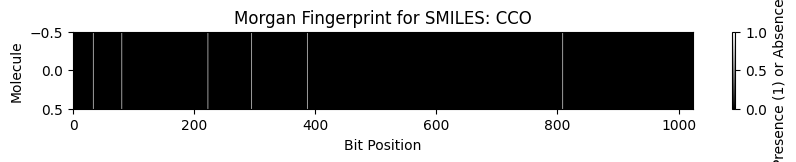

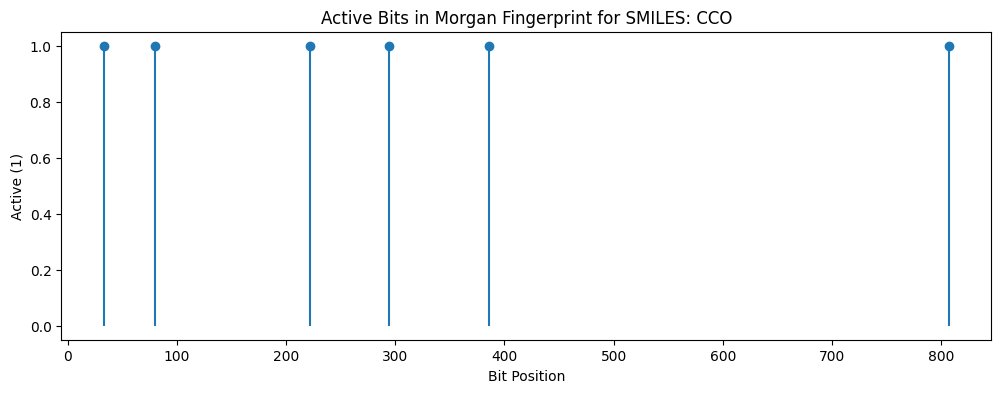

In [57]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt

# Example SMILES string
smiles = "CCO"

# Convert the SMILES string to an RDKit molecule object
molecule = Chem.MolFromSmiles(smiles)

ao = AllChem.AdditionalOutput()
ao.CollectBitInfoMap()

# Compute the Morgan fingerprint
fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024)

# Convert the fingerprint to a numpy array
fingerprint_array = np.zeros((1, 1024), dtype=int)
AllChem.DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_array[0])

# Plot the fingerprint as a heatmap
plt.figure(figsize=(10, 1))
plt.imshow(fingerprint_array, cmap='gray', aspect='auto')
plt.title("Morgan Fingerprint for SMILES: CCO")
plt.xlabel("Bit Position")
plt.ylabel("Molecule")
plt.colorbar(label='Presence (1) or Absence (0)')
plt.show()

# Plot only the bits that are set to 1
active_bits = np.where(fingerprint_array[0] == 1)[0]

plt.figure(figsize=(12, 4))
plt.stem(active_bits, np.ones_like(active_bits), linefmt='-', markerfmt='o', basefmt=' ')
plt.title("Active Bits in Morgan Fingerprint for SMILES: CCO")
plt.xlabel("Bit Position")
plt.ylabel("Active (1)")
plt.show()


In [76]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt

def plot_morgan_fingerprint(smiles, index):
    # Convert the SMILES string to an RDKit molecule object
    molecule = Chem.MolFromSmiles(smiles)
    
    # Compute the Morgan fingerprint
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(molecule, radius=2, nBits=1024)
    
    # Convert the fingerprint to a numpy array
    fingerprint_array = np.zeros((1, 1024), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_array[0])
    
    # Plot the fingerprint as a heatmap
    plt.figure(figsize=(10, 1))
    plt.imshow(fingerprint_array, cmap='gray', aspect='auto')
    plt.title(f"Morgan Fingerprint for SMILES: {index}")
    plt.xlabel("Bit Position")
    plt.ylabel("Molecule")
    plt.colorbar(label='Presence (1) or Absence (0)')
    plt.show()

def process_smiles_list(smiles_list, max_plots=10):
    for index, smiles in enumerate(smiles_list):
        if index >= max_plots:
            break
        print(f"Reactant: {smiles}...")
        plot_morgan_fingerprint(smiles, index)
        print(f"Processed {index + 1} SMILES strings...")


Reactant: CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C...


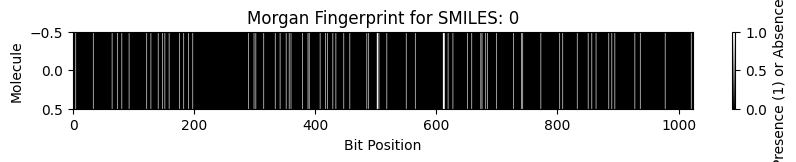

Processed 1 SMILES strings...
Reactant: CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c(C)[n+]1[O-])c(=O)n2C...


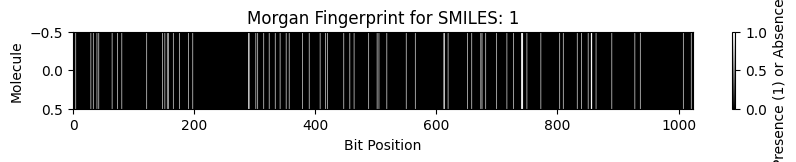

Processed 2 SMILES strings...
Reactant: CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C...


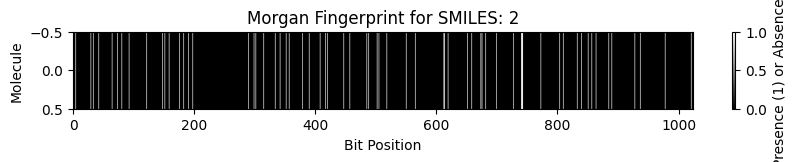

Processed 3 SMILES strings...
Reactant: CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(F)F)cc3)c2)cc1...


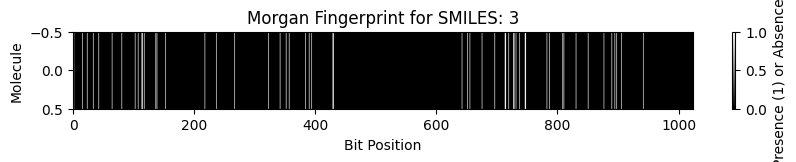

Processed 4 SMILES strings...
Reactant: CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@@H](c3ccc(N(C)C)cc3)C[C@@]21C...


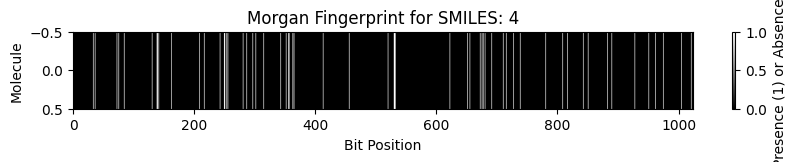

Processed 5 SMILES strings...
Reactant: CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[C@@H](c3ccc(NC)cc3)C[C@@]21C...


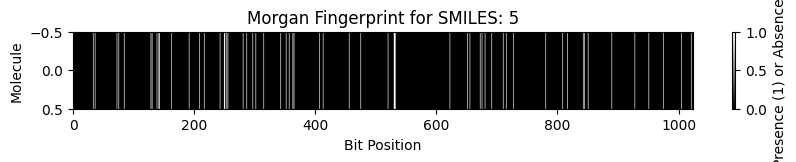

Processed 6 SMILES strings...
Reactant: C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1...


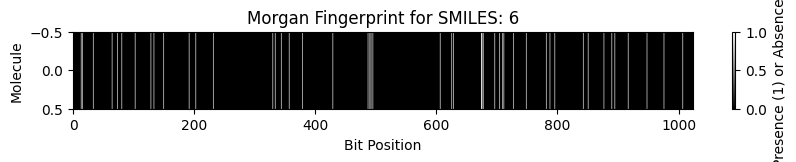

Processed 7 SMILES strings...
Reactant: C#CCC1(C(=O)O)CCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1...


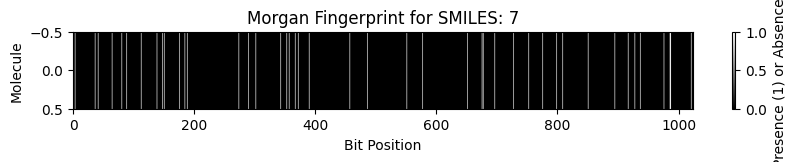

Processed 8 SMILES strings...
Reactant: Cn1c(=O)c2c(nc(S(C)(=O)=O)n2C)n(CC#Cc2cccc(O)c2)c1=O...


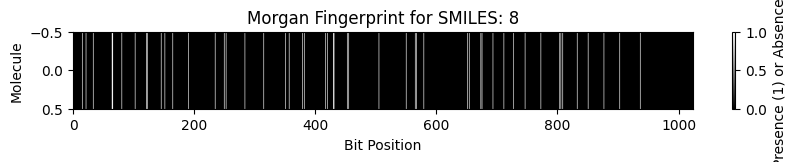

Processed 9 SMILES strings...
Reactant: O=C(O)C#CC1CCCN(C(=O)OCC2c3ccccc3-c3ccccc32)C1...


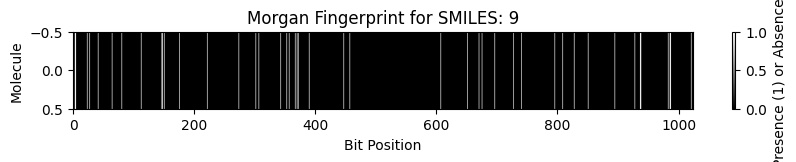

Processed 10 SMILES strings...
Reactant: O=C(O)C#CC1CCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1...


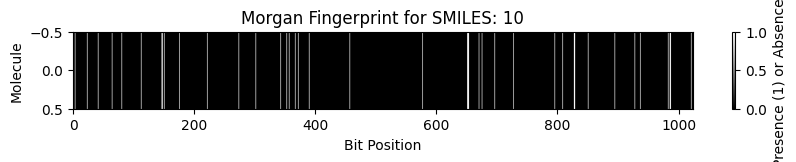

Processed 11 SMILES strings...
Reactant: C#CCC1(C(=O)O)CCCN1C(=O)OCC1c2ccccc2-c2ccccc21...


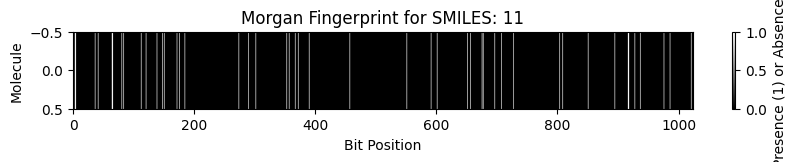

Processed 12 SMILES strings...
Reactant: C#CCC1(C(=O)O)CCN(C(=O)OCC2c3ccccc3-c3ccccc32)C1...


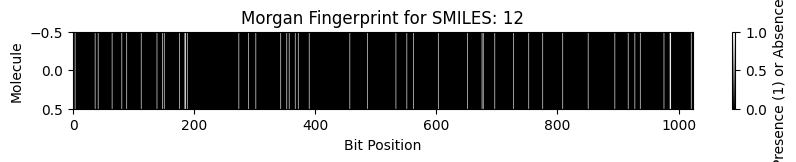

Processed 13 SMILES strings...
Reactant: CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)c(C)c23)C1...


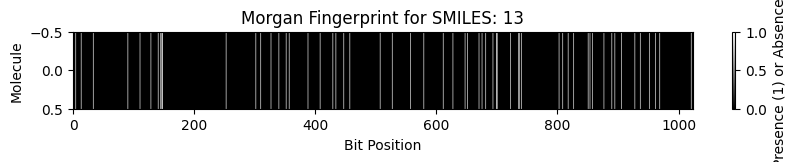

Processed 14 SMILES strings...
Reactant: CC(C)(N)[C@H](NC(=O)c1ccc(C#CC#C[C@@H]2C[C@H]2CO)cc1)C(=O)NO...


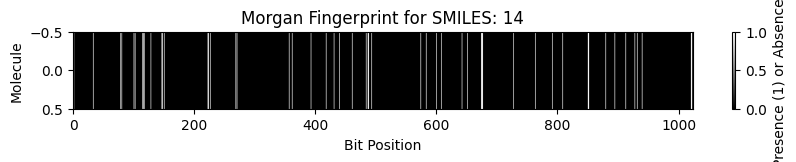

Processed 15 SMILES strings...
Reactant: CCN(CC)CC#CCOC(=O)C(O)(c1ccccc1)C1CCCCC1...


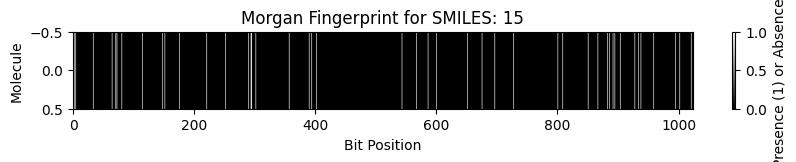

Processed 16 SMILES strings...
Reactant: C#CCNC(=O)c1ccc(NC(=O)c2ccccc2Br)cc1...


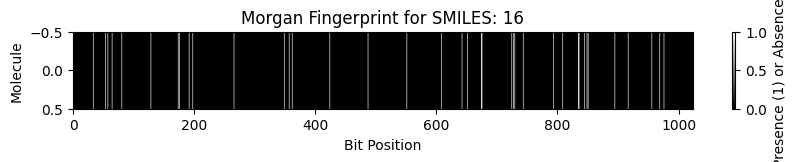

Processed 17 SMILES strings...
Reactant: C#CCC[C@H](NC(=O)OCC1c2ccccc2-c2ccccc21)C(=O)O...


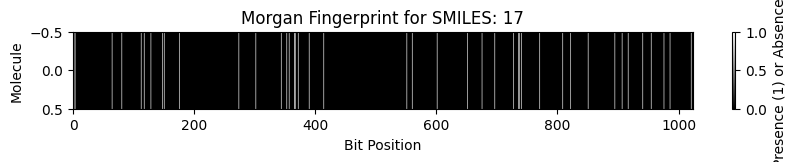

Processed 18 SMILES strings...
Reactant: O=C(O)C#CC1CN(C(=O)OCC2c3ccccc3-c3ccccc32)C1...


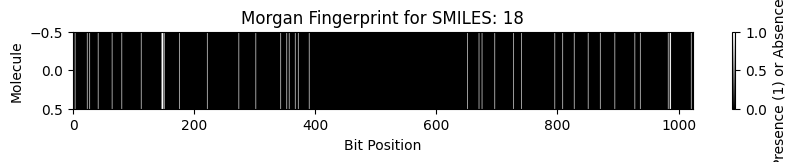

Processed 19 SMILES strings...
Reactant: C#CCCN1CCN(c2ncnc3ccc(Br)cc23)CC1...


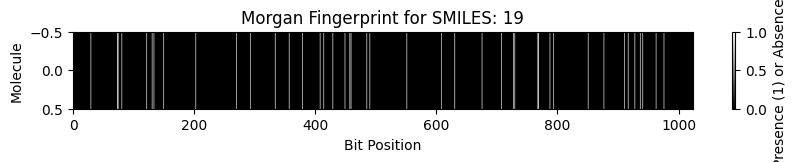

Processed 20 SMILES strings...


In [77]:
# Display plots for the first 10 SMILES strings
process_smiles_list(smiles_list, max_plots=20)

## Split fingerprint tensors

In [60]:
import pickle

# Load the precomputed fingerprints from the pickle file
with open('/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_fpt_uuid.pkl', 'rb') as f:
    smiles_to_fingerprint = pickle.load(f)

In [61]:
# Check the type and some details of the loaded dictionary
print(type(smiles_to_fingerprint))  # Should be a dictionary
print(len(smiles_to_fingerprint))   # Should be the number of SMILES strings (e.g., 150000)
print(next(iter(smiles_to_fingerprint.items())))  # Print the first item to inspect structure

<class 'dict'>
150560
('3e94f0c1b0624942b280005385722079', {'smiles': 'CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C', 'vector': tensor([1., 0., 0.,  ..., 0., 0., 0.])})


In [54]:
2000/129104

0.015491386788945346

In [58]:
int(129104 * 0.015494)

2000

In [71]:
filtered_tensor_dict = {k: v for k, v in smiles_to_fingerprint.items() if v['smiles'] in valid_smiles}

In [73]:
print(len(filtered_tensor_dict))
print(next(iter(filtered_tensor_dict.items())))

129104
('3fd329eb9d544f9291c0d40968942a3c', {'smiles': 'CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c(C)[n+]1[O-])c(=O)n2C', 'vector': tensor([1., 0., 0.,  ..., 0., 0., 0.])})


In [74]:
import random

def split_data(input_dict, split_ratio=0.015494):
    """
    Split a dictionary into two parts based on a given ratio.

    Args:
        input_dict (dict): The dictionary to split.
        split_ratio (float): The ratio for splitting the dictionary. Defaults to 0.5.

    Returns:
        tuple: Two dictionaries split based on the given ratio.
    """
    keys = list(input_dict.keys())
    random.shuffle(keys)

    split_index = int(len(keys) * split_ratio)
    keys1 = keys[:split_index]
    keys2 = keys[split_index:]

    dict1 = {key: input_dict[key] for key in keys1}
    dict2 = {key: input_dict[key] for key in keys2}

    return dict1, dict2

In [75]:
e_val, e_train = split_data(filtered_tensor_dict)

In [76]:
print(f"First dictionary:{len(e_train)}")
print(f"Second dictionary: {len(e_val)}")

First dictionary:127104
Second dictionary: 2000


In [79]:
enamine_val= "/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_val_filtered.pkl"
enamine_train = "/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_train_filtered.pkl"

In [80]:
# Save all vectors to the pickle file
with open(enamine_train, 'wb') as f:
    pickle.dump(e_train, f)

with open(enamine_val, 'wb') as f:
    pickle.dump(e_val, f)

In [83]:
# Load the precomputed fingerprints from the pickle file
with open(enamine_train, 'rb') as f:
    train = pickle.load(f)
with open(enamine_val, 'rb') as f:
    val = pickle.load(f)

In [84]:
print(f"train_size: {len(train)}")
print(f"val_size: {len(val)}")

train_size: 127104
val_size: 2000


# Template data cleaning

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, QED, Draw
import random

In [170]:
temp_full_df = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/reactions.txt",
                           delimiter="|", header=None, names=["Name", "Smarts", "Dingos"]).drop(columns=["Dingos"])

In [171]:
temp_full_df.head()

,Name,Smarts
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(..."
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(..."
2,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)..."
3,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)..."
4,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]..."


In [172]:
temp_full_df.shape

(64, 2)

In [173]:
type = []
for _,t in temp_full_df.iterrows():
    if ">>" not in t.Smarts:
        type.append(t)
print(type)

[]


In [4]:
r_tant = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_building_blocks.csv")
# Load the file
file_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/reactions.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

In [5]:
r_tant = r_tant.SMILES.to_list()

In [176]:
t = lines[14]
print(t)
t = t.split("|")[1]
print(t)
t =  AllChem.ReactionFromSmarts(t)
print(t)
print(f"# Reactants {t.GetNumReactantTemplates()}")
print(f"# Products {t.GetNumProductTemplates()}")

Tetrahydro-Indole_formation|[N$([NH2]([CX4])),N$([NH3+1]([CX4])):1].[O:5]-[C$([CH]([CX4])(C)(O)),C$([CH2]([CX4])(O)):3][C$(C([CX4])(=O)([CX4])),C$([CH]([CX4])(=O)):4]=[O:6]>>[c:4]1[c:3][n+0:1][c:10]2-[C:11]-[C:12]-[C:13]-[C:14]-[c:9]12

[N$([NH2]([CX4])),N$([NH3+1]([CX4])):1].[O:5]-[C$([CH]([CX4])(C)(O)),C$([CH2]([CX4])(O)):3][C$(C([CX4])(=O)([CX4])),C$([CH]([CX4])(=O)):4]=[O:6]>>[c:4]1[c:3][n+0:1][c:10]2-[C:11]-[C:12]-[C:13]-[C:14]-[c:9]12

# Reactants 2
# Products 1


In [184]:
from rdkit import Chem
from rdkit.Chem import AllChem
import csv
import concurrent.futures


def match_template(reactant: str, template: str) -> dict:
    try:
        reaction = AllChem.ReactionFromSmarts(template)
        reactant_mol = Chem.MolFromSmiles(reactant)
        
        if reactant_mol is None:
            return {"first": False, "second": False}

        num_reactants = reaction.GetNumReactantTemplates()
        match_first = False
        match_second = False

        if num_reactants == 1:
            reactant1_template = reaction.GetReactantTemplate(0)
            match_first = reactant_mol.HasSubstructMatch(reactant1_template)
        elif num_reactants == 2:
            reactant1_template = reaction.GetReactantTemplate(0)
            reactant2_template = reaction.GetReactantTemplate(1)
            match_first = reactant_mol.HasSubstructMatch(reactant1_template)
            match_second = reactant_mol.HasSubstructMatch(reactant2_template)

        return {"first": match_first, "second": match_second}
    except Exception as e:
        print(f"Error in matching template: {e}")
        return {"first": False, "second": False}


def check_reactant_compatibility(reactant, templates):
    first_compatible = []
    second_compatible = []

    for template in templates:
        result = match_template(reactant, template)
        if result['first']:
            first_compatible.append(template)
        if result['second']:
            second_compatible.append(template)

    return {
        'reactant': reactant,
        'first_compatible_templates': len(first_compatible),
        'second_compatible_templates': len(second_compatible)
    }


def generate_compatibility_file(reactants, templates, output_file):
    results = []

    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = {executor.submit(check_reactant_compatibility, reactant, templates): reactant for reactant in reactants}

        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            results.append(result)

    # Sort results based on the original order of reactants
    results.sort(key=lambda x: reactants.index(x['reactant']))

    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['reactant', 'first_compatible_templates', 'second_compatible_templates']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for result in results:
            writer.writerow(result)

# Example usage:
reactants = r_tant[:5] # Add more reactants
templates = [line.split("|")[1] for line in lines]
output_file = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/reactant_compatibility.csv'

generate_compatibility_file(reactants, templates, output_file)


In [45]:
comp_r = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/reactant_compatibility_R2.csv")
comp_r[(comp_r["first_compatible_templates"]<=1) & (comp_r["first_compatible_templates"]<=1)]

,reactant,first_compatible_templates,second_compatible_templates
9,O=C(O)C#CC1CCCN(C(=O)OCC2c3ccccc3-c3ccccc32)C1,0,0
10,O=C(O)C#CC1CCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1,0,0
13,CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C...,1,1
18,O=C(O)C#CC1CN(C(=O)OCC2c3ccccc3-c3ccccc32)C1,0,0
20,CC(C)(C)OC(=O)NCC#Cc1ccc(OCc2ccccc2)cc1,0,0
...,...,...,...
150288,CCCCCCCC(=O)S,1,1
150429,CC(=O)NNC(=N)S,1,1
150494,CC(C)C(=O)S,1,1
150510,CCC(=O)S,1,1


In [50]:
comp_r.iloc[13]["reactant"]

'CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)c(C)c23)C1'

In [34]:
list_r = comp_r[(comp_r["first_compatible_templates"]<=1) & (comp_r["second_compatible_templates"]<=1)]["reactant"].tolist()
len(list_r)

15320

In [203]:
import pickle

filepath = "/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_fpt_uuid.pkl"
with open(filepath, 'rb') as file:
    data = pickle.load(file)

In [221]:
len(data)

150560

In [227]:
keys_to_remove = [key for key, value in data.items() if value['smiles'] in list_r]
    
for key in keys_to_remove:
    del data[key]

In [231]:
len(data)

131585

In [19]:
import os

# Function to read reactions from file
def read_reactions(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

# Function to process reactions and generate reversed ones
def process_reactions(reactions):
    processed_reactions = []
    
    for line in reactions:
        name, reaction = line.strip().split('|')
        reactants, product = reaction.split('>>')
        
        # Split reactants by '.' to determine if bimolecular
        reactant_parts = reactants.split('.')
        
        if len(reactant_parts) == 2:
            # Bimolecular reaction: Reverse the reactants
            reactant1, reactant2 = reactant_parts
            reversed_reaction = f'{reactant2}.{reactant1}>>{product}'
            reversed_name = f'{name}_R2'
            processed_reactions.append(f'{reversed_name}|{reversed_reaction}')
        
        # Add the original reaction
        processed_reactions.append(f'{name}|{reaction}')
    
    return processed_reactions

# Function to save processed reactions to a file
def save_reactions(file_path, reactions):
    with open(file_path, 'w') as file:
        for reaction in reactions:
            file.write(reaction + '\n')

# Main script
input_file = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/reactions.txt'
output_file = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/reactions_R2.txt'

# Read, process, and save reactions
reactions = read_reactions(input_file)
processed_reactions = process_reactions(reactions)
save_reactions(output_file, processed_reactions)

print(f"Processed reactions saved to {output_file}")


Processed reactions saved to /rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/reactions_R2.txt


In [53]:
match_temp = []
for line in lines:
    line = line.split("|")[1]
    rxn = AllChem.ReactionFromSmarts(line)
    try:
        if Chem.MolFromSmiles('CC#CC(=O)N[C@H]1CCCN(c2c(F)cc(C(N)=O)c3[nH]c(C)c(C)c23)C1').HasSubstructMatch(rxn.GetReactantTemplate(0), useChirality=True):
            match_temp.append(line)
    except Exception as e:
        print(f"Error: {e}")
        break

In [56]:
print(match_temp[0])

[N$([NH](C)([CX4])),N$([NH2,NH3+1](C)):2]-[C$(C(N)(C)),C$([CH](N)):1]=[O:3].[NH2,NH3+1:13]-[c:8]1[c:7][c:6][c:5][c:4][c:9]1-[C:10](-[OH,O-:12])=[O:11]>>[O:11]=[c:10]-1[n:2][c:1][n:13][c:8]2[c:7][c:6][c:5][c:4][c:9]-12



In [10]:
match_temp

[]

In [132]:
match = []
for r in r_tant:
    try:
        if Chem.MolFromSmiles(r).HasSubstructMatch(t.GetReactantTemplate(0), useChirality=True):
            match.append(r)
    except Exception as e:
        print(f"Error: {e}")
        break

In [133]:
len(match)

21063

In [134]:
match[:10]

['CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c(C)[n+]1[O-])c(=O)n2C',
 'CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)c3ccccc3n1)c(=O)n2C',
 'CC(C)(N)[C@H](NC(=O)c1ccc(C#CC#C[C@@H]2C[C@H]2CO)cc1)C(=O)NO',
 'CCCNC(=O)C(C)NC(=O)c1csc(C#CCN)c1',
 'C#CCCCC(N)c1ccc(Br)cc1',
 'C#CCNC(=O)C(C)SCC(N)C(=O)O',
 'CS(=O)(=O)Nc1cccc(C#CCN)c1',
 'C#CC(N)c1ccc(Br)cc1',
 'C#CCOc1ccc(CN)cc1OCC',
 'C[Si](C)(C)C#Cc1ccc(CN)cc1']

In [135]:
random.choice(match)

'CC(C)(C)OC(=O)N1CCOCC1CN'

In [136]:
match2 = []
for r in r_tant:
    try:
        if Chem.MolFromSmiles(r).HasSubstructMatch(t.GetReactantTemplate(1), useChirality=True):
            match2.append(r)
    except Exception as e:
        print(f"Error: {e}")
        break

In [137]:
len(match2)

128

In [138]:
match2[:10]

['O=C1CC[C@@]2(O)[C@H]3Cc4ccc(O)c5c4[C@@]2(CCN3CC2CC2)[C@H]1O5',
 'CC(C)(C)OC(=O)N1C2CCC1C(O)C(=O)C2',
 'CCOC(=O)CCC(=O)C(C)O',
 'CC(O)C(=O)C1(C)CCCCC1',
 'CC(O)C(=O)Cc1ccccc1',
 'CC(O)C(=O)C1CCCCC1',
 'COC(C)CC(=O)C(C)O',
 'O=C1CCOCC1O',
 'CC(O)C(=O)C1CC1',
 'O=C1CCCC1O']

In [139]:
random.choice(match2)

'CC(=O)C1CN(C(=O)OC(C)(C)C)CCO1'

In [140]:
# Convert the SMILES string to an RDKit molecule object
mol = Chem.MolFromSmiles(random.choice(match))
mol2 = Chem.MolFromSmiles(random.choice(match2))

# Check if the molecule was loaded correctly
if mol:
    # Sanitize the molecule (catch errors to see if any issues arise)
    try:
        Chem.SanitizeMol(mol)
        print("Molecule sanitized successfully.")
    except Chem.rdchem.KekulizeException as e:
        print(f"Sanitization error: {e}")
    
    # Visualize the molecule
    img = Draw.MolToImage(mol)
    img.show()
else:
    print("Failed to create molecule from SMILES.")

# Check if the molecule was loaded correctly
if mol2:
    # Sanitize the molecule (catch errors to see if any issues arise)
    try:
        Chem.SanitizeMol(mol2)
        print("Molecule sanitized successfully.")
    except Chem.rdchem.KekulizeException as e:
        print(f"Sanitization error: {e}")
    
    # Visualize the molecule
    img2 = Draw.MolToImage(mol2)
    img2.show()
else:
    print("Failed to create molecule from SMILES.")

Molecule sanitized successfully.
Molecule sanitized successfully.


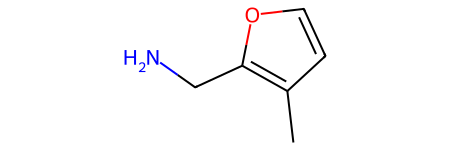

In [142]:
mol

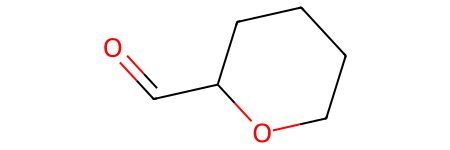

In [143]:
mol2

In [185]:
test = "[C$(C(=C)([CX4])):2]=[C$(C(=C)([CX4])):1].[N$(N(~N)([CX4])):5]~[N]~[N]>>[C:2]1[C:1][N:5][N]=[N]1"
test = AllChem.ReactionFromSmarts(test)
ps = test.RunReactants((Chem.MolFromSmiles("CC[C@@H](O)CNC"), Chem.MolFromSmiles("CC(C)N=[N+]=[N-]")))
# Check and correct mapping
corrected_products = []
for product_set in ps:
    for product in product_set:
        try:
            Chem.SanitizeMol(product)
            corrected_products.append(product)
        except Exception as e:
            print(f"Error in sanitization: {e}")
            corrected_products.append(product)
            continue

In [186]:
print(f"ps: {ps}")
print(f"corrected_products: {corrected_products}")

ps: ()
corrected_products: []


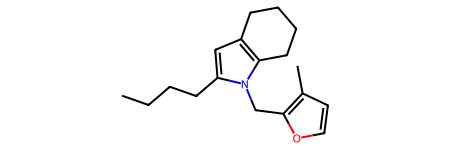

In [155]:
ps[0][0]

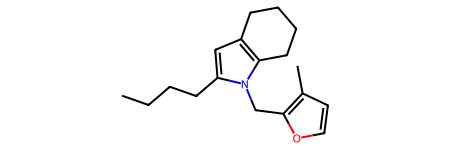

In [157]:
corrected_products[0]

In [158]:
print(f"QED ps: {QED.qed(ps[0][0])}")
print(f"QED santized: {QED.qed(corrected_products[0])}")

QED ps: 0.7731970980084973
QED santized: 0.7731970980084973


## Temp_R2 Cleaning

In [2]:
temp_R2 = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/template_compatibility_R2.csv")
temp_R2.shape

(113, 4)

In [3]:
temp_R2.head(20)

,Template,Type,First Reactants Compatible,Second Reactants Compatible
0,Bischler-Napieralski,unimolecular,159,0
1,Pictet-Gams,unimolecular,9,0
2,Pictet-Spengler-6-membered-ring_R2,bimolecular,976,1254
3,Pictet-Spengler-6-membered-ring,bimolecular,1254,976
4,Pictet-Spengler-5-membered-ring_R2,bimolecular,976,129
5,Pictet-Spengler-5-membered-ring,bimolecular,129,976
6,Bischler-Indole_R2,bimolecular,150,7409
7,Bischler-Indole,bimolecular,7409,150
8,Benzimidazol_formation_R2,bimolecular,297,19838
9,Benzimidazol_formation,bimolecular,19838,297


In [14]:
# Drop bimolecular templates with less than 40 second reactants
condition = (temp_R2["Type"]=="bimolecular") & (temp_R2["Second Reactants Compatible"]<40)

In [23]:
temp_R2_filtered = temp_R2[~condition].reset_index(drop=True)
temp_R2_filtered.shape

(102, 4)

In [26]:
temp_R2_filtered.head(20)

,Template,Type,First Reactants Compatible,Second Reactants Compatible
0,Bischler-Napieralski,unimolecular,159,0
1,Pictet-Gams,unimolecular,9,0
2,Pictet-Spengler-6-membered-ring_R2,bimolecular,976,1254
3,Pictet-Spengler-6-membered-ring,bimolecular,1254,976
4,Pictet-Spengler-5-membered-ring_R2,bimolecular,976,129
5,Pictet-Spengler-5-membered-ring,bimolecular,129,976
6,Bischler-Indole_R2,bimolecular,150,7409
7,Bischler-Indole,bimolecular,7409,150
8,Benzimidazol_formation_R2,bimolecular,297,19838
9,Benzimidazol_formation,bimolecular,19838,297


In [27]:
temp_R2_filtered.to_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/template_compatibility_R2_filtered.csv", index=False)

In [28]:
file_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/reactions_R2.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

In [36]:
valid_templates_names = temp_R2_filtered["Template"].tolist()

In [37]:
valid_templates_details = []
for index, line in enumerate(lines):
    if line.split("|")[0] in valid_templates_names:
        valid_templates_details.append(line)
    else:
        continue

In [41]:
file_path = '/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/reactions_R2_filtered.txt'
with open(file_path, 'w') as file:
    for item in valid_templates_details:
        file.write(f"{item}")

print(f"List saved to {file_path}")

List saved to /rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/reactions_R2_filtered.txt


## Clean Smiles

In [42]:
building_blocks = pd.read_csv("/rds/user/gtj21/hpc-work/designing-new-molecules/data/reactant_compatibility_R2_filtered.csv")
building_blocks.shape

(150560, 3)

In [43]:
building_blocks.head(20)

,reactant,first_compatible_templates,second_compatible_templates
0,CC#CCn1c(N2CCCC(NC(N)=O)C2)nc2c1c(=O)n(Cc1nc(C...,1,2
1,CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c...,6,8
2,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...,6,8
3,CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...,13,12
4,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,6,5
5,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,8,7
6,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,3,3
7,C#CCC1(C(=O)O)CCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1,11,13
8,Cn1c(=O)c2c(nc(S(C)(=O)=O)n2C)n(CC#Cc2cccc(O)c...,5,3
9,O=C(O)C#CC1CCCN(C(=O)OCC2c3ccccc3-c3ccccc32)C1,0,0


In [50]:
condition = (building_blocks["first_compatible_templates"]>1) & (building_blocks["second_compatible_templates"]>1)

In [51]:
blocks_R2_filtered = building_blocks[condition].reset_index(drop=True)
blocks_R2_filtered.shape

(129104, 3)

In [52]:
blocks_R2_filtered.head(20)

,reactant,first_compatible_templates,second_compatible_templates
0,CC#CCn1c(N2CCCC(N)C2)nc2c1c(=O)n(Cc1nc3ccccc3c...,6,8
1,CC#CCn1c(N2CCC[C@@H](N)C2)nc2c1c(=O)n(Cc1nc(C)...,6,8
2,CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...,13,12
3,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,6,5
4,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,8,7
5,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,3,3
6,C#CCC1(C(=O)O)CCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1,11,13
7,Cn1c(=O)c2c(nc(S(C)(=O)=O)n2C)n(CC#Cc2cccc(O)c...,5,3
8,C#CCC1(C(=O)O)CCCN1C(=O)OCC1c2ccccc2-c2ccccc21,11,13
9,C#CCC1(C(=O)O)CCN(C(=O)OCC2c3ccccc3-c3ccccc32)C1,11,13


In [68]:
valid_smiles = set(blocks_R2_filtered["reactant"])
len(valid_smiles)

129104

In [86]:
with open(enamine_val, 'rb') as f:
    val = pickle.load(f)

In [90]:
val_smiles = [info['smiles'] for info in val.values()]
len(val_smiles)

2000

In [106]:
file_path = "/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/reactions_R2_filtered.txt"
rtn = pd.read_csv(file_path, delimiter="|", header=None, names=["Reaction", "Smarts"])
rtn.head(10)

,Reaction,Smarts
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(..."
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(..."
2,Pictet-Spengler-6-membered-ring_R2,"[CH:10](-[CX4:12])=[O:11].[NH3+,NH2]-[C$(C(N)(..."
3,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)..."
4,Pictet-Spengler-5-membered-ring_R2,"[CH:10](-[CX4:12])=[O:11].[NH3+,NH2]-[C$(C(N)(..."
5,Pictet-Spengler-5-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)..."
6,Bischler-Indole_R2,"[Br:18][C$([CH2](C)(Br)),C$([CH](C)(C)(Br)):17..."
7,Bischler-Indole,"[NH2,NH3+1:8]-[c:5]1[cH:4][c:3][c:2][c:1][c:6]..."
8,Benzimidazol_formation_R2,"[NH2,NH3+:12]-[c:9]1[c:8][c:7][c:6][c:5][c:10]..."
9,Benzimidazol_formation,"[OH,O-]-[C$(C([CX4])),C$([CH]):2]=[O:3].[NH2,N..."


In [108]:
def get_reaction_type(smarts):
    try:
        # Create a reaction object from the SMARTS string
        reaction = AllChem.ReactionFromSmarts(smarts)
        
        # Get the number of reactant templates
        num_reactants = reaction.GetNumReactantTemplates()
        
        if num_reactants == 1:
            return 'unimolecular'
        elif num_reactants == 2:
            return 'bimolecular'
        else:
            return 'other'  # In case there are reactions with more than two reactants
    except Exception as e:
        print(f"Error processing SMARTS '{smarts}': {e}")
        return 'invalid'

In [110]:
rtn["Type"] = rtn["Smarts"].apply(get_reaction_type)
rtn.head()

,Reaction,Smarts,Type
0,Bischler-Napieralski,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
1,Pictet-Gams,"[$(C([CH2,CH3])),CH:10](=[O:11])-[NH+0:9]-[C$(...",unimolecular
2,Pictet-Spengler-6-membered-ring_R2,"[CH:10](-[CX4:12])=[O:11].[NH3+,NH2]-[C$(C(N)(...",bimolecular
3,Pictet-Spengler-6-membered-ring,"[NH3+,NH2]-[C$(C(N)(C)(C)(C)),C$([CH](N)(C)(C)...",bimolecular
4,Pictet-Spengler-5-membered-ring_R2,"[CH:10](-[CX4:12])=[O:11].[NH3+,NH2]-[C$(C(N)(...",bimolecular


# Supervised Learning

In [19]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

# Load the datasets
smiles_data = pd.read_csv('/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/enamine_building_blocks.csv')
templates_data = pd.read_csv('/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/rxn_set_processed.txt', delimiter="|")

templates_data = templates_data[templates_data["Type"]=="unimolecular"].reset_index(drop=True)

In [23]:
# Convert SMILES strings to molecules
smiles_data['mol'] = smiles_data['SMILES'].apply(Chem.MolFromSmiles)

# Convert templates to reaction objects
templates_data['rxn'] = templates_data['Smarts'].apply(AllChem.ReactionFromSmarts)

In [26]:
# Function to check if a molecule matches a template
def match_template(mol, rxn):
    try:
        num_reactants = rxn.GetNumReactantTemplates()
        if num_reactants == 1:
            reactant1_template = rxn.GetReactantTemplate(0)
            return mol.HasSubstructMatch(reactant1_template, useChirality=True)
        return False
    except Exception as e:
        print(f"Error matching template: {e}")
        return False

In [27]:
# Create an empty DataFrame for the applicability matrix
applicability_matrix = pd.DataFrame(index=smiles_data.index, columns=templates_data.index, data=0)

In [28]:
applicability_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150555,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150557,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150558,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Fill the applicability matrix
for i, mol in enumerate(smiles_data['mol']):
    for j, rxn in enumerate(templates_data['rxn']):
        if match_template(mol, rxn):
            applicability_matrix.iloc[i, j] = 1

In [34]:
# Combine the SMILES data with the applicability matrix
result = pd.concat([smiles_data['SMILES'], applicability_matrix], axis=1)
result.columns = ['SMILES'] + [f'template_{i+1}' for i in templates_data.index]

# Remove rows where no templates are applicable
result['sum'] = result.iloc[:, 1:].sum(axis=1)  # Sum the template columns to identify rows with all zeros
result = result[result['sum'] > 0].drop(columns=['sum']).reset_index(drop=True)  # Keep only rows where the sum is greater than 0 and drop the sum column

In [35]:
result

,SMILES,template_1,template_2,template_3,template_4,template_5,template_6,template_7,template_8,template_9,template_10,template_11,template_12,template_13,template_14,template_15
0,CC#C[C@@H](CC(=O)O)c1ccc(OCc2cccc(-c3ccc(C(F)(...,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
1,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,CC#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CCC4=C3[...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,C#CCC1(C(=O)O)CCN(C(=O)OCC2c3ccccc3-c3ccccc32)CC1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,Cn1c(=O)c2c(nc(S(C)(=O)=O)n2C)n(CC#Cc2cccc(O)c...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68033,COC(=O)C1(NC(=O)OC(C)(C)C)CC(CN)C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
68034,COc1cc(C=O)c([N+](=O)[O-])cc1OCC(=O)O,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
68035,COC(=O)C1(CN)CN(C(=O)OC(C)(C)C)C1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
68036,COC(=O)C[C@H](CN)NC(=O)OC(C)(C)C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [36]:
# Save the resulting DataFrame to a CSV file
result.to_csv('/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/supervised_dataset.csv', index=False)

## Data preparation

In [38]:
from sklearn.model_selection import train_test_split
from rdkit.Chem import AllChem

# Load the formatted dataset
data = pd.read_csv('/rds/user/gtj21/hpc-work/designing-new-molecules/data/preprocessed_data/supervised_dataset.csv')

# Convert SMILES to molecular fingerprints
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

data['fingerprint'] = data['SMILES'].apply(smiles_to_fingerprint)

# Split the dataset
X = list(data['fingerprint'])
y = data.iloc[:, 1:-1].values  # Template applicability columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

# Define a simple neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 15)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

KeyboardInterrupt: 

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Using L2 loss as discussed
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss}")
    
    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')


In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

# Additional evaluation metrics (if needed)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming a threshold of 0.5 for binary classification
def evaluate_model(model, dataloader, threshold=0.5):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predicted = (outputs > threshold).int()
            y_true.extend(targets.numpy())
            y_pred.extend(predicted.numpy())
    
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = evaluate_model(model, test_loader)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")
